In [1]:
import sys
import xarray as xr
import glob
import dask
import matplotlib.pyplot as plt
import cmocean
import time
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32985")
client

<Client: 'tcp://127.0.0.1:32985' processes=12 threads=96, memory=502.56 GiB>

In [3]:
ds = xr.open_zarr('https://surftemp-sst.s3.us-west-2.amazonaws.com/data/sst.zarr')

drifter_file_path = '../data/process/gdp_v2.00.nc'
dr = xr.open_dataset(drifter_file_path,chunks={})

In [4]:
traj_idx = np.insert(np.cumsum(dr.rowsize.values), 0, 0)

In [ ]:
# one interp

In [5]:
%%time
i = 0
sli = slice(traj_idx[i], traj_idx[i+1])
dsi = ds.analysed_sst.interp(lon=dr.longitude[sli],lat=dr.latitude[sli],
                time=dr.time[sli]).data.compute()

CPU times: user 129 ms, sys: 18.7 ms, total: 147 ms
Wall time: 1.72 s


In [8]:
dsi[:10]

array([293.02407065, 293.04031341, 293.04063594, 293.03720703,
       293.02376255, 292.98684983, 292.91657416, 292.89909547,
       292.89021965, 292.87106279])

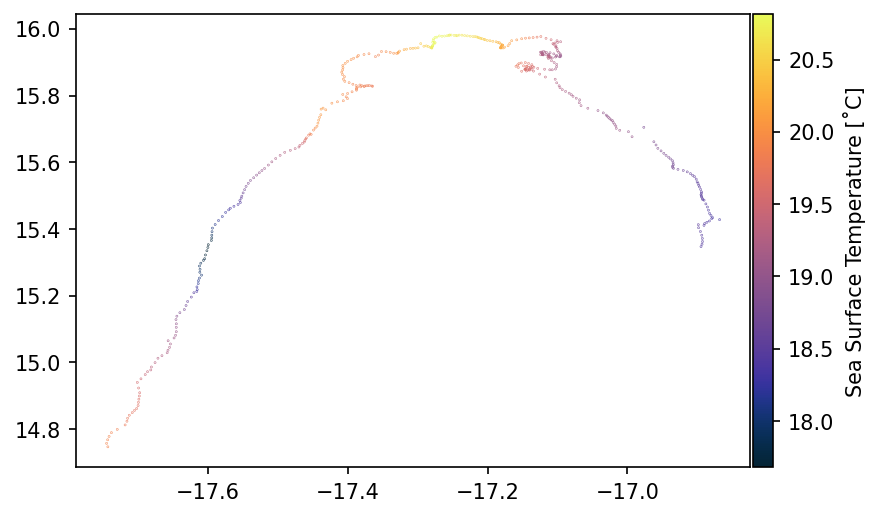

In [9]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot()
pcm = ax.scatter(dr.longitude[sli],dr.latitude[sli],s=0.05,c=dsi-273.15,cmap=cmocean.cm.thermal)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax)
cb.set_label('Sea Surface Temperature [˚C]')


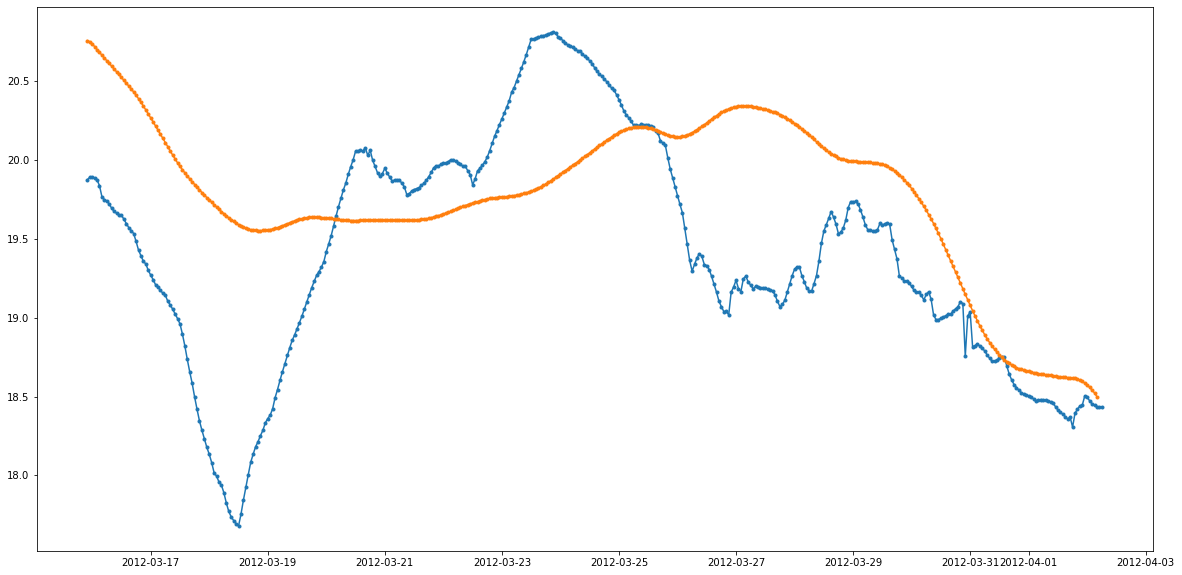

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
c1 = plt.plot(dr.time[sli],dsi-273.15,marker='.')
c2 = plt.plot(dr.time[sli],dr.sst1[sli]-273.15,marker='.')

In [11]:
# with dask

In [12]:
def interp_sst(i):
    sli = slice(traj_idx[i], traj_idx[i+1])
    return ds.analysed_sst.interp(lon=dr.longitude[sli],lat=dr.latitude[sli],time=dr.time[sli]).data

In [13]:
# this work for small values
# but doesn't scale properly.
values = []
for i in range(0, 10):
    values.append(interp_sst(i))

In [14]:
%%time
values = dask.compute(*values)

CPU times: user 84.8 ms, sys: 11.5 ms, total: 96.3 ms
Wall time: 19.2 s


In [15]:
len(values)

10

In [16]:
values[3]

array([301.15623203, 301.15769643, 301.15949641, ...,          nan,
                nan,          nan])